<a href="https://colab.research.google.com/github/akjha47/multiClassTextClassification/blob/master/Copy_of_textClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#preparing data
#using Glove word vectors
#downloaded from https://nlp.stanford.edu/projects/glove/


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
pathToVecFile='drive/My Drive/word2vec.txt'
word2index={'PAD':0}
weights=[]
with open(pathToVecFile,'r') as file: 
    for index, line in enumerate(file): 
        values = line.split()
        word = values[0]
        word_weights = np.asarray(values[1:], dtype=np.float32)
        word2index[word] = index + 1 
        weights.append(word_weights)
        if index+1==40000:#limiting vocabulary size to 40k
          break
UNKNOWN_TOKEN=len(weights)
EMBEDDING_DIMENSION=len(weights[0])
weights.insert(0, np.random.randn(EMBEDDING_DIMENSION))
word2index['UNK'] = UNKNOWN_TOKEN
weights.append(np.random.randn(EMBEDDING_DIMENSION))

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import re
stop_words = set(stopwords.words("english"))
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    return tokens
def getVectors(text):
  features={}
  required_vector=np.zeros((300,50))
  text2convert=text_cleaner(text)
  features['word_indices'] = [word2index.get(word, UNKNOWN_TOKEN) for word in text2convert]
  for index,word_indices in enumerate(features['word_indices']):
    if(index>299):
      break
    required_vector[index]=weights[word_indices]
  return required_vector




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


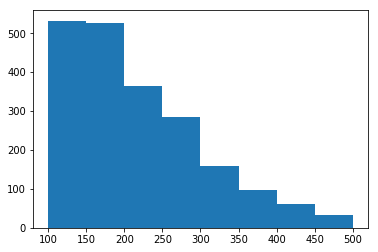

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
#reading data
import pandas as pd
dataF=pd.read_csv('drive/My Drive/bbc-text.csv')
from matplotlib import pyplot as plt
bins=[100,150,200,250,300,350,400,450,500]
length=[]
for entries in dataF.iloc[:,1]:
  length.append(len(text_cleaner(entries)))
plt.hist(length,bins,histtype='bar')
plt.show()
#choosing 300 as the max length
X=np.zeros((2225,300,50))
Y=dataF.iloc[:,0]
for index,entries in enumerate(dataF.iloc[:,1]):
  word_vectors=getVectors(entries)
  X[index,:,:]=word_vectors
#one hot encoding Y
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# integer encode
integer_encoded = LabelEncoder().fit_transform(array(Y))
# binary encode
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y= OneHotEncoder(sparse=False).fit_transform(integer_encoded)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , Y, test_size=0.3, random_state=42)


In [0]:
import tensorflow as tf
model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,dropout=0.1,return_sequences=True,input_shape=(300,50)),
    tf.keras.layers.LSTM(128,dropout=0.2),
    tf.keras.layers.Dense(5,activation='softmax')
])
class EarlyStoppingByAccVal(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_acc', value=0.98, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            print('Validation Accuracy is higher than 98%, hence stopping the training....')
            self.model.stop_training = True
callbacks = [
    EarlyStoppingByAccVal(monitor='val_acc', value=0.98, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('drive/My Drive/model.h5', monitor='acc', save_best_only=True, verbose=0)
]
adam_optimizer=tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 300, 128)          91648     
_________________________________________________________________
lstm_35 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 645       
Total params: 223,877
Trainable params: 223,877
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64,validation_split=0.2,callbacks=callbacks)


Train on 1245 samples, validate on 312 samples
Epoch 1/100
1245/1245 [==============================] - 36s 29ms/sample - loss: 1.5792 - acc: 0.3333 - val_loss: 1.1736 - val_acc: 0.4583
Epoch 2/100
1245/1245 [==============================] - 28s 23ms/sample - loss: 1.2005 - acc: 0.4835 - val_loss: 1.0961 - val_acc: 0.5801
Epoch 3/100
1245/1245 [==============================] - 28s 23ms/sample - loss: 1.3110 - acc: 0.4466 - val_loss: 1.1962 - val_acc: 0.5256
Epoch 4/100
1245/1245 [==============================] - 28s 23ms/sample - loss: 1.0529 - acc: 0.6353 - val_loss: 0.8448 - val_acc: 0.7692
Epoch 5/100
1245/1245 [==============================] - 29s 23ms/sample - loss: 0.8428 - acc: 0.7502 - val_loss: 1.6694 - val_acc: 0.4872
Epoch 6/100
1245/1245 [==============================] - 28s 23ms/sample - loss: 1.2715 - acc: 0.4851 - val_loss: 1.1274 - val_acc: 0.5449
Epoch 7/100
1245/1245 [==============================] - 28s 23ms/sample - loss: 1.3554 - acc: 0.4329 - val_loss: 1.475

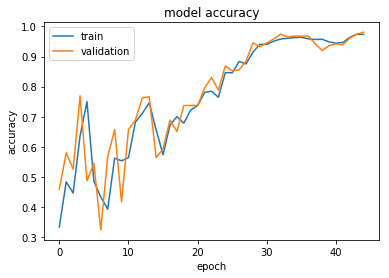

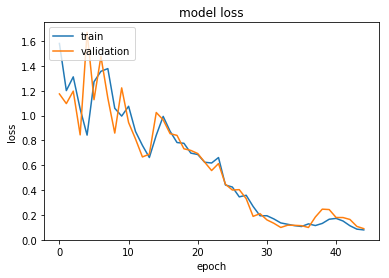

In [0]:
import matplotlib.pyplot as plt
#  plotting Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [0]:
model.evaluate(X_test,y_test)

668/668 [==============================] - 10s 16ms/sample - loss: 0.0989 - acc: 0.9701


[0.09892060165990613, 0.9700599]